<a href="https://colab.research.google.com/github/janbanot/msc-cs-code/blob/main/sem3/DL/DL_2025__lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Co potrafi neuron?

## Wstęp

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# torch.nn.Module jest klasą bazową dla sieci i ich modułów
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.layer = nn.Linear(1, 1, bias=True)  # 1 wej. 1 wyj.
        self.act = nn.Identity()  # f. aktywacji

    def forward(self, x):
        return self.act(self.layer(x))

    def set_weights_example(self):
        # Ustaw wart. parametrów ręcznie:
        with torch.no_grad():
            self.layer.weight.fill_(2)  # w = 2
            self.layer.bias.fill_(0)    # b = 0

In [2]:
model = Net1()

pred = model(torch.tensor([1.0]))  # predykcja modelu, czyli w*x + b = 2*x + 0 = 2
print(f'{pred = }')

# Możemy obliczyć wynik dla wielu przykładów jednocześnie
X = torch.tensor([[1.5],
                  [-3]])
pred = model(X)
for x, p in zip(X, pred):
    print(f'Dla x = {x.item()} predykcja = {p.item()}')  # item() wyciąga liczbę z tensora

pred = tensor([0.8184], grad_fn=<ViewBackward0>)
Dla x = 1.5 predykcja = 0.766730785369873
Dla x = -3.0 predykcja = 1.2318687438964844


In [3]:
# Podgląd wartości wagi i bias
model.layer.weight, model.layer.bias

(Parameter containing:
 tensor([[-0.1034]], requires_grad=True),
 Parameter containing:
 tensor([0.9218], requires_grad=True))

In [4]:
# state_dict() zwraca informację o wszystkich parametrach oraz tzw. buforach modelu
model.state_dict()

OrderedDict([('layer.weight', tensor([[-0.1034]])),
             ('layer.bias', tensor([0.9218]))])

In [5]:
# Zamiast losowych możemy wymusić własne wartości wag
model.set_weights_example()

pred = model(X)
for x, p in zip(X, pred):
    print(f'Dla x = {x.item()} predykcja = {p.item()}')  # item() wyciąga liczbę z tensora

Dla x = 1.5 predykcja = 3.0
Dla x = -3.0 predykcja = -6.0


## Klasyfikacja 1D

Jeden neuron z nieliniową f. aktywacji, np. sigmoidalną, może dokonać **klasyfikacji binarnej** dla liniowo separowalnych klas.

In [6]:
# Dane treningowe
X = torch.tensor([[1.],
                  [0.5],
                  [1.5],
                  [2]])
y = torch.tensor([[0],
                  [0],
                  [1],
                  [1]], dtype=torch.int)

# Nasz model
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.layer = nn.Linear(1, 1, bias=True)  # 1 wej. 1 wyj.
        self.act = nn.Sigmoid()  # f. aktywacji

    def forward(self, x):
        return self.act(self.layer(x))

    def set_weights(self, w, b):
        with torch.no_grad():
            self.layer.weight.fill_(w)
            self.layer.bias.fill_(b)


model = Net2()
w, b = -2, -1.
model.set_weights(w, b)

Narysujmy wykres dla naszego neuronu


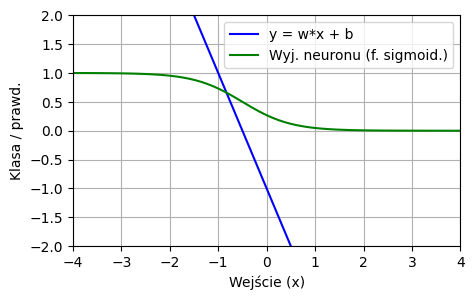

In [7]:
import matplotlib.pyplot as plt


def plot_net2_a(model, show=True):
    plt.figure(figsize=(5, 3))
    plt.xlim(-4, 4)
    plt.ylim(-2, 2)

    # Prosta określona przez parametry naszego neuronu
    x_range = torch.linspace(-5, 5, 100).unsqueeze(1)
    plt.plot(x_range, model.layer(x_range).detach().numpy(), 'b-', label='y = w*x + b')

    # Wynik aktywacji neuronu
    y_sigmoid = model(x_range).detach().numpy()  # .detach() odłącza od grafu obliczeń
    plt.plot(x_range, y_sigmoid, 'g-', label='Wyj. neuronu (f. sigmoid.)')

    plt.xlabel('Wejście (x)')
    plt.ylabel('Klasa / prawd.')
    plt.legend()
    plt.grid(True)

    if show:
      plt.show()

plot_net2_a(model)

F. sigmoidalna zwraca wart. z zakresu [0, 1], które możemy traktować jak prawopodobieństwo przynależności do klasy 1, tj.
 - dla wart. < 0.5 mamy klasę 0
 - dla wart. >= 0.5 mamy klasę 1

**Granica decyzyjna** leży dokładnie w pkt. dla którego `sigmoid(x) = 0.5`

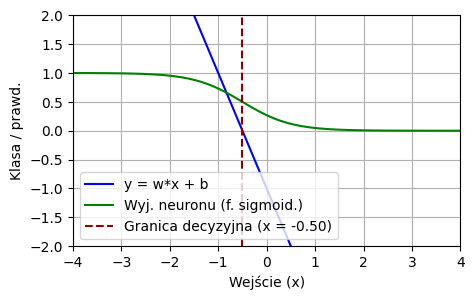

In [8]:
def plot_net2_b(model, show=True):
    plot_net2_a(model, show=False)

    # Granica
    w, b = model.layer.weight.item(), model.layer.bias.item()
    decision_boundary = -b / w   # w*x + b = 0 (sigmoid = 0.5), czyli x = -b/w
    # Wykres
    plt.axvline(x=decision_boundary, color='darkred', linestyle='--', label=f'Granica decyzyjna (x = {decision_boundary:.2f})')
    plt.legend()
    if show:
        plt.show()

plot_net2_b(model)


Jakie są **predykcje klas** dokonywane przez nasz model dla danych treningowych?

In [9]:
pred = model(X)

klasa = (pred >= 0.5).int()

for x, p, k in zip(X, pred, klasa):
    print(f'Dla x = {x.item()} predykcja = {p.item():.2f} klasa {k.item()}')  # item() wyciąga liczbę z tensora

Dla x = 1.0 predykcja = 0.05 klasa 0
Dla x = 0.5 predykcja = 0.12 klasa 0
Dla x = 1.5 predykcja = 0.02 klasa 0
Dla x = 2.0 predykcja = 0.01 klasa 0


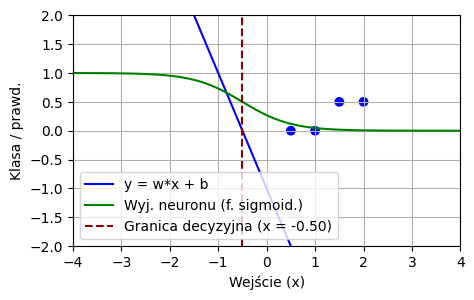

In [10]:
# Narysujmy to

def plot_net2_c(model, X, y, show=True):
    plot_net2_b(model, show=False)

    pred = model(X)
    klasa = (pred >= 0.5).int()

    colors = ('blue', 'red')
    # Przykłady z danych wejściowych
    plt.scatter(X, y*0.5, c=[colors[k] for k in klasa], marker='o')

    if show:
        plt.show()


plot_net2_c(model, X, y)

## Zad. 1.

Proszę znaleźć parametry modelu, dla którego model poprawnie klasyfikuje przykłady, tj. dwa pierwsze do klasy 0 (niebieski kolor), dwa pozostałe
do klasy 1 (czerwony).

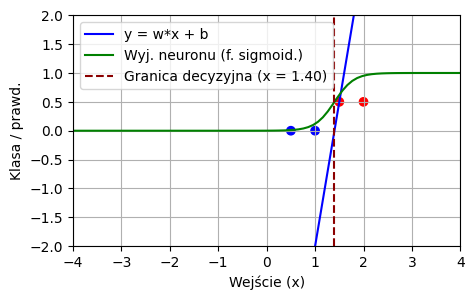

In [13]:
# Rozwiązanie...
model = Net2()
w, b = 5, -7

model.set_weights(w, b)
plot_net2_c(model, X, y)

# Co potrafi sieć?

In [14]:
# Załóżmy, że nasze dane wyglądają tak

# Dane treningowe
X = torch.tensor([[-2],
                  [-1.5],
                  [1.],
                  [0.5],
                  [1.5],
                  [2]])

y = torch.tensor([[1],
                  [1],
                  [0],
                  [0],
                  [1],
                  [1]], dtype=torch.int)

### **Pytanie** Czy możemy je poprawnie klasyfikować za pomocą *pojedynczego* neuronu?

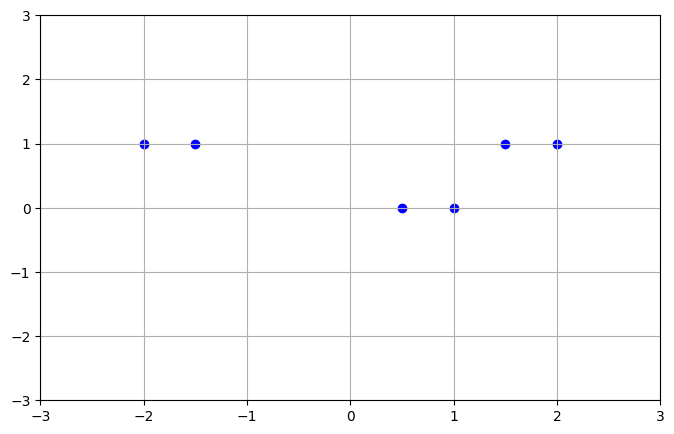

In [15]:
def plot_zad2(X, y, show=True):
    plt.figure(figsize=(8, 5))
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)

    plt.scatter(X, y, c='blue', marker='o')
    plt.grid(True)

    if show:
      plt.show()

plot_zad2(X, y)

Jak widać, potrzebujemy *większej* liczby neuronów połączonych w **sieć**.

          +---Neuron 1 [w1[0],b1[0]]
          |                         \
    (x) --+                          *-- Neuron 3 [w2, b2] ->
          |                         /
          +---Neuron 2 [w1[1],b1[1]]

## Zad 2.

Spróbuj dobrać parametry modelu tak aby model poprawnie dokonywał klasyfikacji dla przykładowych danych.

Działanie poszczególnych elementów widoczne jest na wykresie.

In [16]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

# Dane treningowe
X = torch.tensor([[-2], [-1.5], [1.], [0.5], [1.5], [2]])
y = torch.tensor([[1], [1], [0], [0], [1], [1]], dtype=torch.float)

def plot_network(w1_0=1.0, w1_1=-1.0, b1_0=0.0, b1_1=-2.0, w2_0=1.0, w2_1=1.0, b2_0=0.0):
    # Parametry sieci jako tensory
    w1 = torch.tensor([[w1_0], [w1_1]])
    b1 = torch.tensor([b1_0, b1_1])
    w2 = torch.tensor([[w2_0], [w2_1]])  # Kształt: (2, 1)
    b2 = torch.tensor([b2_0])

    # Zakres wejść [-5, 5] na potrzeby wykresu
    x_range = torch.linspace(-5, 5, 100).unsqueeze(1)

    # Oblicz wyjścia modelu (sieci)
    layer1_output = F.relu(x_range @ w1.T + b1)  # Kształt: (100, 2)
    output = F.sigmoid(layer1_output @ w2 + b2)   # Kształt: (100, 1)

    # Konwertuj na numpy
    x_range_np = x_range.squeeze().numpy()
    layer1_np = layer1_output.detach().numpy()
    output_np = output.detach().numpy()

    # Oblicz predykcje modelu (sieci) dla danych treningowych
    layer1_train = F.relu(X @ w1.T + b1)
    pred = F.sigmoid(layer1_train @ w2 + b2).detach().numpy().squeeze()

    # Dane treningowe numpy na potrzeby wykresu
    X_np = X.squeeze().numpy()
    y_np = y.squeeze().numpy()

    # Kolory dla punktów danych na podstawie predykcji (pomarańczowy region jeśli >0.5)
    point_colors = ['orange' if p > 0.5 else 'blue' for p in pred]

    plt.figure(figsize=(15, 5))

    for i, (data, title, color, label) in enumerate([
        (layer1_np[:, 0], 'Warstwa 1 - Neuron 1', 'blue', f'w1_0={w1_0:.1f}, b1_0={b1_0:.1f}'),
        (layer1_np[:, 1], 'Warstwa 1 - Neuron 2', 'green', f'w1_1={w1_1:.1f}, b1_1={b1_1:.1f}'),
        (output_np.squeeze(), 'Warstwa wyjściowa', 'red', 'Wynik')
    ], 1):
        plt.subplot(1, 3, i)
        plt.plot(x_range_np, data, color=color, label=label)

        if i == 3:  # Dodaj tylko tło i dane tylko do wykresu wyjściowego
            plt.scatter(X_np, y_np, c=point_colors, marker='o', label='Dane (pred >0.5: pomarańczowe)')
            # Tło
            ax = plt.gca()
            mask = (output_np.squeeze() > 0.5)
            ax.fill_between(x_range_np, -2, 2, where=mask, color='lightgreen', alpha=0.3, label='Wyjście > 0.5')

        plt.title(title)
        plt.xlabel('Wejście (x)')
        plt.ylabel('Wyjście (y)')
        plt.xlim([-3, 3])
        plt.ylim([-2, 2])
        plt.grid(True)
        plt.legend()

    plt.tight_layout()
    plt.show()

# Utwórz interaktywne suwaki (dostosuj zakresy w razie potrzeby)
interact(plot_network,
         w1_0=FloatSlider(min=-5, max=5, step=0.1, value=1.0, description='w1_0'),
         w1_1=FloatSlider(min=-5, max=5, step=0.1, value=-1.0, description='w1_1'),
         b1_0=FloatSlider(min=-5, max=5, step=0.1, value=0.0, description='b1_0'),
         b1_1=FloatSlider(min=-5, max=5, step=0.1, value=-2.0, description='b1_1'),
         w2_0=FloatSlider(min=-5, max=5, step=0.1, value=1.0, description='w2_0'),
         w2_1=FloatSlider(min=-5, max=5, step=0.1, value=1.0, description='w2_1'),
         b2_0=FloatSlider(min=-5, max=5, step=0.1, value=0.0, description='b2_0'));

interactive(children=(FloatSlider(value=1.0, description='w1_0', max=5.0, min=-5.0), FloatSlider(value=-1.0, d…

## Model PyTorch

Zaimplementujmy model sieci obiektowo za pomocą PyTorch

In [17]:
class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        # Ile wyjść tyle neuronów
        self.hidden_layer = nn.Linear(1, 2, bias=True)  # 1 wej. 2 wyj.
        self.h_act = nn.ReLU()  # f. aktywacji
        self.out_layer = nn.Linear(2, 1, bias=True)  # 2 wej. 1 wyj.
        self.act = nn.Sigmoid()  # f. aktywacji

    def forward(self, x):
        h = self.h_act(self.hidden_layer(x))
        return self.act(self.out_layer(h))

    def set_weights(self, w1_1, w1_2, b1_1, b1_2, w2_1, w2_2, b2):
        with torch.no_grad():
            self.hidden_layer.weight.data = torch.tensor([[w1_1], [w1_2]], dtype=torch.float)
            self.hidden_layer.bias.data = torch.tensor([b1_1, b1_2], dtype=torch.float)
            self.out_layer.weight.data = torch.tensor([[w2_1, w2_2]], dtype=torch.float)
            self.out_layer.bias.data = torch.tensor([b2], dtype=torch.float)


model = Net3()

model.set_weights(w1_1=0.5, b1_1=0,   # Neuron 1.1 (w. ukryta)
                  w1_2=2, b1_2=0,     # Neuron 1.2 (w. ukryta)
                  w2_1=1, w2_2=1, b2=-1)   # Neuron wyj.

print(f'Parametry modelu:\n {model.state_dict()}')
print(f'Wyjście: {model(X)}\npredykowana klasa:\n{(model(X) > 0.5).long()}')

Parametry modelu:
 OrderedDict({'hidden_layer.weight': tensor([[0.5000],
        [2.0000]]), 'hidden_layer.bias': tensor([0., 0.]), 'out_layer.weight': tensor([[1., 1.]]), 'out_layer.bias': tensor([-1.])})
Wyjście: tensor([[0.2689],
        [0.2689],
        [0.8176],
        [0.5622],
        [0.9399],
        [0.9820]], grad_fn=<SigmoidBackward0>)
predykowana klasa:
tensor([[0],
        [0],
        [1],
        [1],
        [1],
        [1]])


## Trening automatyczny

In [18]:
import torch.optim as optim

model = Net3()
# Definicja funkcji straty i optymalizatora
criterion = nn.BCELoss()  # Binary Cross Entropy Loss dla klasyfikacji binarnej
optimizer = optim.SGD(model.parameters(), lr=0.1)  # Stochastic Gradient Descent

# Parametry treningu
num_epochs = 500

# Pętla treningowa
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X)
    loss = criterion(outputs, y.float())

    # Backward pass i optymalizacja
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Wyświetlanie postępu co 100 epok
    if epoch % 100 == 0:
        print(f'Epoka [{epoch+1}/{num_epochs}], Strata: {loss.item():.4f}')

# Sprawdzenie dokładności po treningu
with torch.no_grad():
    predicted = model(X)
    predicted = (predicted >= 0.5).long()  # Próg 0.5 dla klasyfikacji binarnej
    accuracy = (predicted.eq(y.float()).sum() / y.shape[0]).item()
    print(f'Dokładność modelu na wszystkich danych: {accuracy:.4f}')

print(model.state_dict())

Epoka [1/500], Strata: 0.7564
Epoka [101/500], Strata: 0.4851
Epoka [201/500], Strata: 0.4414
Epoka [301/500], Strata: 0.3814
Epoka [401/500], Strata: 0.2980
Dokładność modelu na wszystkich danych: 1.0000
OrderedDict({'hidden_layer.weight': tensor([[-1.9506],
        [ 1.6058]]), 'hidden_layer.bias': tensor([ 0.4658, -0.5286]), 'out_layer.weight': tensor([[1.7890, 1.4704]]), 'out_layer.bias': tensor([-1.8297])})


## Sposoby zapisu modeli z użyciem PyTorch



### Styl sekwencyjny

In [19]:
class Net3(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 2, bias=True),  # warstwa ukryta: 1 wejście -> 2 neurony
            nn.ReLU(),                   # funkcja aktywacji ReLU
            nn.Linear(2, 1, bias=True),  # warstwa wyjściowa: 2 wejścia -> 1 neuron
            nn.Sigmoid()                 # funkcja aktywacji Sigmoid
        )

    def forward(self, x):
        return self.model(x)

module = Net3()
module.state_dict()

OrderedDict([('model.0.weight',
              tensor([[-0.0848],
                      [-0.5565]])),
             ('model.0.bias', tensor([-0.4531, -0.4215])),
             ('model.2.weight', tensor([[ 0.6316, -0.2028]])),
             ('model.2.bias', tensor([0.2799]))])

Zalety:
- Zwięzły i czytelny zapis.
- Idealny dla prostych, liniowych sieci bez rozgałęzień.

Wady:
- Trudno podejrzeć wartości pośrednie (np. aktywacje po warstwie ukrytej).

### Styl funkcyjny

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net3(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_layer = nn.Linear(1, 2, bias=True)
        self.out_layer = nn.Linear(2, 1, bias=True)

    def forward(self, x):
        h = F.relu(self.hidden_layer(x))       # aktywacja ReLU
        y = torch.sigmoid(self.out_layer(h))   # aktywacja Sigmoid
        return y

module = Net3()
module.state_dict()

OrderedDict([('hidden_layer.weight',
              tensor([[-0.2621],
                      [ 0.3838]])),
             ('hidden_layer.bias', tensor([-0.0037, -0.0422])),
             ('out_layer.weight', tensor([[-0.1034, -0.0683]])),
             ('out_layer.bias', tensor([0.6811]))])

Zalety:
- Duża elastyczność -- łatwo dodać np. połączenia rezydualne lub własne operacje.
- Styl często używany w dokumentacji PyTorcha i w badaniach naukowych.

Wady:
- Nieco bardziej rozwlekły zapis.
- Wymaga jawnego wywoływania funkcji aktywacji.

### Styl modularny


In [21]:
class Net3(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleDict({
            "hidden": nn.Linear(1, 2),
            "out": nn.Linear(2, 1)
        })
        self.h_act = nn.ReLU()
        self.out_act = nn.Sigmoid()

    def forward(self, x):
        x = self.h_act(self.layers["hidden"](x))
        x = self.out_act(self.layers["out"](x))
        return x

module = Net3()
module.state_dict()

OrderedDict([('layers.hidden.weight',
              tensor([[ 0.2128],
                      [-0.8057]])),
             ('layers.hidden.bias', tensor([ 0.3553, -0.2082])),
             ('layers.out.weight', tensor([[-0.3424, -0.4183]])),
             ('layers.out.bias', tensor([0.6044]))])

Zalety:
- Łatwo modyfikować i wymieniać warstwy w czasie eksperymentów.
- Warstwy mają nazwy, co ułatwia przeglądanie modelu i zapisywanie konfiguracji.

Wady:
- Dla prostych sieci wprowadza niepotrzebny narzut.

# Zad 3. Zb. Iris (2D)

Na podstawie rozwiązania poprzedniego zadania zaimplementuj model
`NetIris` oraz dokonaj jego treningu z pomocą PyTorch.

## Dane

In [22]:
from sklearn import datasets

# Załaduj zestaw danych Iris
iris = datasets.load_iris()
X, y = iris.data, iris.target

# Wybierz tylko pierwsze dwie cechy: długość płatka i szerokość płatka
X = X[:, 0:2]

# Połącz klasy 1 (versicolor) i 2 (virginica) w jedną klasę (1)
# Klasa 0 pozostaje bez zmian (setosa)
y = np.where(y == 2, 1, y)  # Wszystkie "2" zastąp "1"
X[::10], y[::10]  # Pokaż co 10-ty zestaw danych

(array([[5.1, 3.5],
        [5.4, 3.7],
        [5.4, 3.4],
        [4.8, 3.1],
        [5. , 3.5],
        [7. , 3.2],
        [5. , 2. ],
        [5.9, 3.2],
        [5.5, 2.4],
        [5.5, 2.6],
        [6.3, 3.3],
        [6.5, 3.2],
        [6.9, 3.2],
        [7.4, 2.8],
        [6.7, 3.1]]),
 array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))

### Wykresy pomocnicze

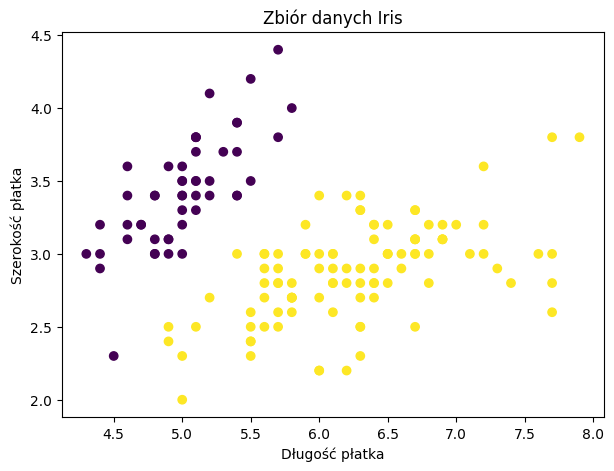

In [23]:
def plot_iris1(X, y):
    # Wykres danych
    fig = plt.figure(figsize=(7, 5))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
    plt.xlabel('Długość płatka')
    plt.ylabel('Szerokość płatka')
    plt.title('Zbiór danych Iris')
    plt.show()

plot_iris1(X, y)

In [24]:
def plot_iris_with_decision_boundary(X, y, model):
    # Przygotowanie siatki punktów do wyznaczenia granicy decyzyjnej
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    # Przekształć siatkę na tensor i przewidź klasy
    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
    with torch.no_grad():
        Z = model(grid).numpy()
    Z = Z.reshape(xx.shape)

    # Rysowanie wykresu
    fig = plt.figure(figsize=(7, 5))
    plt.contourf(xx, yy, Z, levels=[0, 0.5, 1], alpha=0.2, cmap='viridis')  # Granica decyzyjna
    plt.contour(xx, yy, Z, levels=[0.5], colors='black', linestyles='--')  # Linia granicy
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolors='k')  # Punkty danych
    plt.xlabel('Długość płatka')
    plt.ylabel('Szerokość płatka')
    plt.title('Zbiór danych Iris z granicą decyzyjną')
    plt.show()


### Model

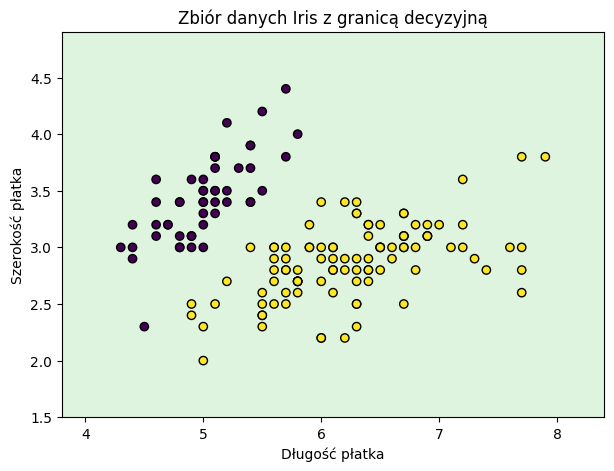

In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NetIris(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_layer = nn.Linear(2, 2, bias=True)
        self.out_layer = nn.Linear(2, 1, bias=True)

    def forward(self, x):
        h = F.relu(self.hidden_layer(x))       # aktywacja ReLU
        y = torch.sigmoid(self.out_layer(h))   # aktywacja Sigmoid
        return y

model = NetIris()
model.state_dict()

plot_iris_with_decision_boundary(X, y, model)

### Trening

In [61]:
import torch.optim as optim
import torch

model = NetIris()
# Definicja funkcji straty i optymalizatora
criterion = nn.BCELoss()  # Binary Cross Entropy Loss dla klasyfikacji binarnej
optimizer = optim.SGD(model.parameters(), lr=0.1)  # Stochastic Gradient Descent

# Convert NumPy arrays to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)


# Parametry treningu
num_epochs = 500

# Pętla treningowa
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_tensor)
    loss = criterion(outputs, y_tensor)

    # Backward pass i optymalizacja
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Wyświetlanie postępu co 100 epok
    if epoch % 100 == 0:
        print(f'Epoka [{epoch+1}/{num_epochs}], Strata: {loss.item():.4f}')

# Sprawdzenie dokładności po treningu
with torch.no_grad():
    predicted = model(X_tensor)
    predicted = (predicted >= 0.5).long()  # Próg 0.5 dla klasyfikacji binarnej
    accuracy = (predicted.eq(y_tensor.long()).sum() / y_tensor.shape[0]).item()
    print(f'Dokładność modelu na wszystkich danych: {accuracy:.4f}')

print(model.state_dict())

Epoka [1/500], Strata: 0.6518
Epoka [101/500], Strata: 0.4446
Epoka [201/500], Strata: 0.2176
Epoka [301/500], Strata: 0.1309
Epoka [401/500], Strata: 0.0928
Dokładność modelu na wszystkich danych: 0.9933
OrderedDict({'hidden_layer.weight': tensor([[-0.5698,  0.5551],
        [ 1.5548, -2.2072]]), 'hidden_layer.bias': tensor([ 0.3999, -0.6456]), 'out_layer.weight': tensor([[-0.6389,  2.7329]]), 'out_layer.bias': tensor([-2.0975])})


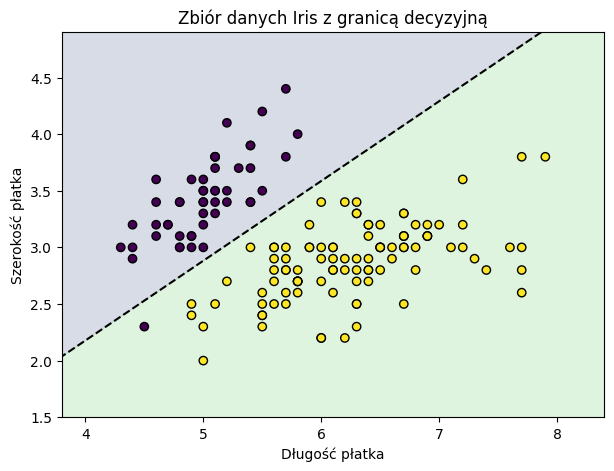

In [62]:
plot_iris_with_decision_boundary(X, y, model)

## Poprawki

### Podział na zb. treningowy i walidacyjny



W przypadku treningu sieci neuronowych (i nie tylko), ważny jest podział zbioru danych na część *treningową i testową*.

W przypadku, gdy nasz zbiór jest odpowiednio duży i planujemy dostrajać **hiperparametry** modelu, np. liczbę warstw, neuronów, współczynnik szybkości uczenia, to dobrym pomysłem jest podział na 3 części: *treningową, walidacyjną oraz testową*.

Część walidacyjna zastępuje testową w trakcie naszego procesu doboru hiperparametrów, a część testowa używana jest do oceny finalnego modelu.

In [63]:
from sklearn.model_selection import train_test_split

# Załaduj zestaw danych Iris
iris = datasets.load_iris()
X, y = iris.data, iris.target

# Wybierz tylko pierwsze dwie cechy: długość płatka i szerokość płatka
X = X[:, 0:2]
# Połącz klasy 1 (versicolor) i 2 (virginica) w jedną klasę (1)
y = np.where(y == 2, 1, y)

# Podział na część treningową oraz walidacyjną w proporcji 80 / 20
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# PyTorch operuje na tensorach, więc dokonujemy konwersji z np.array
# na torch.Tensor:
x_train = torch.FloatTensor(x_train)
y_train = torch.FloatTensor(y_train).view(-1, 1)

x_test = torch.FloatTensor(x_test)
y_test = torch.FloatTensor(y_test).view(-1, 1)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

(torch.Size([120, 2]),
 torch.Size([120, 1]),
 torch.Size([30, 2]),
 torch.Size([30, 1]))

### Trening

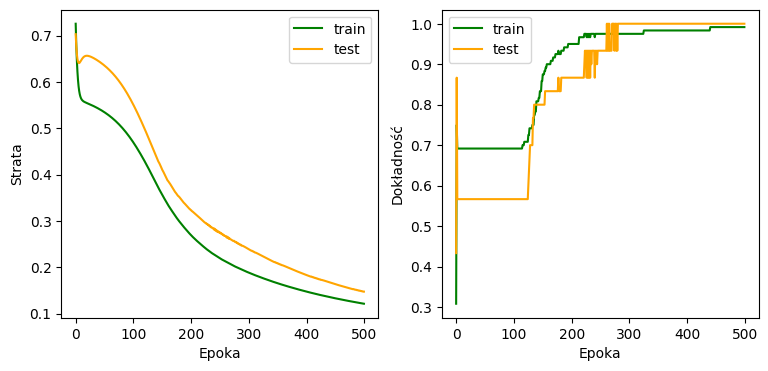

/tmp/ipython-input-3632471841.py:5: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
/tmp/ipython-input-3632471841.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  np.arange(y_min, y_max, 0.01))


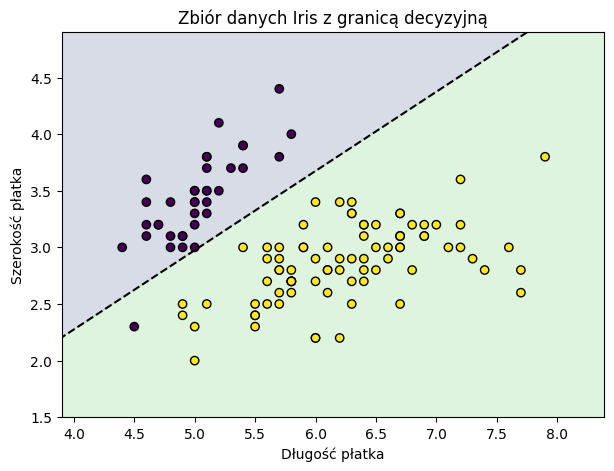

In [64]:
from collections import defaultdict

# Przyda się możliwość obliczania dokładności predykcji modelu
def compute_accuracy(model_output, y_true):
    with torch.no_grad():  # Nie twórz grafu obliczeniowego
        predicted = (model_output >= 0.5).float()  # Próg 0.5 dla klasyfikacji binarnej
        accuracy = (predicted.eq(y_true).sum() / y_true.shape[0]).item()
    return accuracy


model = NetIris()

compute_loss = nn.BCELoss()  # Binary Cross Entropy Loss dla klasyfikacji binarnej

# Hiperparametry dla treningu:
n_iterations = 500
eval_every = 1
learning_rate = 0.05
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

history = defaultdict(list)

# Trening modelu
for i in range(n_iterations):
    model.train()  # Przełącz w tryb treningu

    out = model(x_train)  # Inferencja (faza w przód)
    loss = compute_loss(out, y_train)

    history['train_loss'].append(loss.item())
    history['train_accuracy'].append(compute_accuracy(out, y_train))

    if i % eval_every == 0:  # Policz stratę i dokł. na zb. testowym
        model.eval()   # Przełącz w tryb ewaluacji
        with torch.no_grad():  # Nie licz gradientów
            out = model(x_test)

            history['test_loss'].append(compute_loss(out, y_test).item())
            history['test_accuracy'].append(compute_accuracy(out, y_test))

    loss.backward()   # Policz gradienty (faza wstecz)
    optimizer.step()  # Aktualizuj parametry modelu
    optimizer.zero_grad()  # Zerowanie gradientów przed kolejną iteracją


# Wizualizacja historii treningu:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))  # 1 wiersz, 2 kolumny

# Strata
ax1.set_ylabel('Strata')
ax1.set_xlabel('Epoka')
ax1.plot(range(n_iterations), history['train_loss'], color='green')
ax1.plot(range(0, n_iterations, eval_every), history['test_loss'], color='orange')
ax1.legend(['train', 'test'])

ax2.set_ylabel('Dokładność')
ax2.set_xlabel('Epoka')
ax2.plot(range(n_iterations), history['train_accuracy'], color='green')
ax2.plot(range(0, n_iterations, eval_every), history['test_accuracy'], color='orange')
ax2.legend(['train', 'test'])

plt.show()

plot_iris_with_decision_boundary(x_train, y_train, model)

# Zad 4. -- Pełen zbiór Iris

Dokonaj klasyfikacji dla pełnego zbioru Iris, tj. 4 cechy wejściowe
oraz 3 klasy.

In [116]:
# TODO przygotowanie danych
# z podziałem na zbiór treningowy oraz testowy

from sklearn.model_selection import train_test_split

# Załaduj zestaw danych Iris
iris = datasets.load_iris()
X, y = iris.data, iris.target

# Podział na część treningową oraz walidacyjną w proporcji 80 / 20
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# PyTorch operuje na tensorach, więc dokonujemy konwersji z np.array
# na torch.Tensor:
x_train = torch.FloatTensor(x_train)
y_train = torch.LongTensor(y_train)

x_test = torch.FloatTensor(x_test)
y_test = torch.LongTensor(y_test)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

(torch.Size([120, 4]),
 torch.Size([120]),
 torch.Size([30, 4]),
 torch.Size([30]))

Nasz model będzie miał 5 neuronów w warstwie ukrytej. Każdy z 4 wejściami
na wartości cech. Trzy wyjścia (po jednym na klasę), których wartości są **"logitami"** (ang. logits), tj. $$z_i = Wx + b$$ dla i-tego wyjścia.

Wyjście dla którego wartość jest największa wskazuje klasę predykowaną przez sieć. Alternatywnie, na podstawie logitów możemy obliczyć
prawdopodobieństwa przynależności do konkretnej klasy $i$ za pomocą
funkcji **softmax**:

$$P(y = i) = \frac{e^{z_i}}{\sum_{j=1}^{C} e^{z_j}}$$



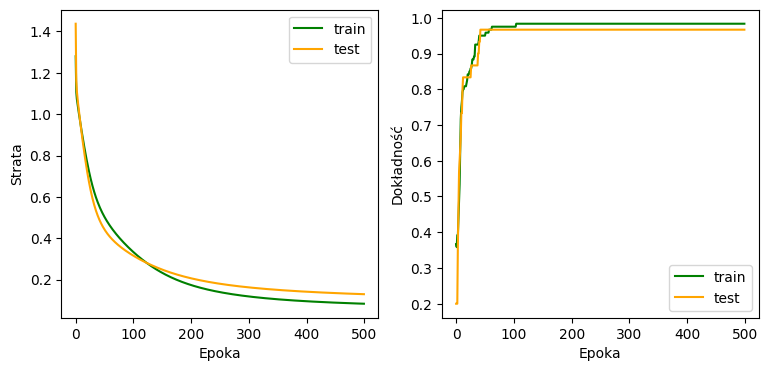

In [121]:
# Hiperparametry modelu:
n_inputs = 4
n_outputs = 3  # bo 3 klasy
n_hidden = 5

model = nn.Sequential(
    nn.Linear(n_inputs, n_hidden),
    # nn.ReLU(),
    nn.Linear(n_hidden, n_outputs)
)

# F. straty -- dla zadania klasyfikacji z l. klas > 2:
# CrossEntropyLoss pracuje z logitami
compute_loss = nn.CrossEntropyLoss()

# TODO
# Hiperparametry dla treningu:
n_iterations = 500
eval_every = 1
learning_rate = 0.05
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

history = defaultdict(list)

# Trening modelu
for i in range(n_iterations):
    model.train()  # Przełącz w tryb treningu

    out = model(x_train)  # Inferencja (faza w przód)
    loss = compute_loss(out, y_train)

    history['train_loss'].append(loss.item())
    # CrossEntropyLoss pracuje z logitami, więc bierzemy argmax do compute_accuracy
    with torch.no_grad():
        predicted = torch.argmax(out, -1)
        accuracy = (predicted == y_train).float().mean().item()
        history['train_accuracy'].append(accuracy)


    if i % eval_every == 0:  # Policz stratę i dokł. na zb. testowym
        model.eval()   # Przełącz w tryb ewaluacji
        with torch.no_grad():  # Nie licz gradientów
            out = model(x_test)

            history['test_loss'].append(compute_loss(out, y_test).item())
            # CrossEntropyLoss pracuje z logitami, więc bierzemy argmax do compute_accuracy
            predicted = torch.argmax(out, -1)
            accuracy = (predicted == y_test).float().mean().item()
            history['test_accuracy'].append(accuracy)


    loss.backward()   # Policz gradienty (faza wstecz)
    optimizer.step()  # Aktualizuj parametry modelu
    optimizer.zero_grad()  # Zerowanie gradientów przed kolejną iteracją


# Wizualizacja historii treningu:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))  # 1 wiersz, 2 kolumny

# Strata
ax1.set_ylabel('Strata')
ax1.set_xlabel('Epoka')
ax1.plot(range(n_iterations), history['train_loss'], color='green')
ax1.plot(range(0, n_iterations, eval_every), history['test_loss'], color='orange')
ax1.legend(['train', 'test'])

ax2.set_ylabel('Dokładność')
ax2.set_xlabel('Epoka')
ax2.plot(range(n_iterations), history['train_accuracy'], color='green')
ax2.plot(range(0, n_iterations, eval_every), history['test_accuracy'], color='orange')
ax2.legend(['train', 'test'])

plt.show()

# Porcjowanie danych

Jak dotąd stosowaliśmy trening na całym zbiorze treningowym, jednak algorytm SGD (i inne) zakłada, że trening wykonywany jest na **grupach** lub porcjach (ang. batch) przykładów.

`PyTorch` udostępnia klasę `DataLoader`, która upraszcza proces iterowania po kolejnych grupach przykładów.

In [122]:
from torch.utils.data import DataLoader

dummy_data = torch.tensor(np.arange(10)).unsqueeze(-1)


print('Cały zbiór:', dummy_data)

print('Iteruję po grupach: ')
for batch in DataLoader(dataset=dummy_data, batch_size=2):
    print(batch)


print('\nIteruję po grupach (losowa kolejność): ')
for batch in DataLoader(dataset=dummy_data, batch_size=2, shuffle=True):
    print(batch)

print('\nPonownie iteruję po grupach (losowa kolejność): ')
for batch in DataLoader(dataset=dummy_data, batch_size=2, shuffle=True):
    print(batch)

Cały zbiór: tensor([[0],
        [1],
        [2],
        [3],
        [4],
        [5],
        [6],
        [7],
        [8],
        [9]])
Iteruję po grupach: 
tensor([[0],
        [1]])
tensor([[2],
        [3]])
tensor([[4],
        [5]])
tensor([[6],
        [7]])
tensor([[8],
        [9]])

Iteruję po grupach (losowa kolejność): 
tensor([[5],
        [9]])
tensor([[8],
        [7]])
tensor([[6],
        [0]])
tensor([[4],
        [2]])
tensor([[1],
        [3]])

Ponownie iteruję po grupach (losowa kolejność): 
tensor([[2],
        [8]])
tensor([[3],
        [6]])
tensor([[0],
        [4]])
tensor([[5],
        [1]])
tensor([[7],
        [9]])


Nasz kod po uwzględnieniu grupowania będzie wyglądał następująco.

In [123]:
# Podział na część treningową oraz walidacyjną w proporcji 80 / 20
x_train, x_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.2, random_state=42)

x_train = torch.Tensor(x_train)
y_train = torch.LongTensor(y_train)  # Tensor z 64-bitowymi intami
x_test = torch.Tensor(x_test)
y_test = torch.LongTensor(y_test)

# PyTorch operuje na tensorach, więc dokonujemy konwersji z np.array
# na torch.Tensor:
train_loader = DataLoader(list(zip(x_train, y_train)), batch_size=30, shuffle=True)
test_loader = DataLoader(list(zip(x_test, y_test)), batch_size=30, shuffle=False)

Możemy zdefiniować pomocnicze funkcje do treningu i rysowania wykresów.

In [124]:
def train_model(model, train_loader, test_loader, optimizer, n_epochs=500, eval_every=10):
    history = defaultdict(list)
    # F. straty -- dla zadania klasyfikacji z l. klas > 2:
    compute_loss = nn.CrossEntropyLoss()
    # Trening modelu
    for epoch in range(n_epochs):
        model.train()  # Przełącz w tryb treningu

        total_loss = 0
        total_samples = 0
        total_correct = 0
        # Epoka to przejście po całym zbiorze treningowym:
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()  # Zerowanie gradientów przed kolejną iteracją
            out = model(x_batch)  # Inferencja (faza w przód)

            loss = compute_loss(out, y_batch)

            loss.backward()   # Policz gradienty (faza wstecz)
            optimizer.step()  # Aktualizuj parametry modelu

            total_samples += x_batch.shape[0]
            total_loss += loss.item() * x_batch.shape[0]

            predicted = torch.argmax(out, -1)
            total_correct += (predicted == y_batch).sum().item()

        history['train_loss'].append(total_loss / total_samples)
        history['train_accuracy'].append(total_correct / total_samples)

        if epoch % eval_every == 0:  # Policz stratę i dokł. na zb. testowym
            model.eval()   # Przełącz w tryb ewaluacji
            total_loss = 0
            total_samples = 0
            total_correct = 0
            with torch.no_grad():  # Nie licz gradientów
                for x_batch, y_batch in test_loader:
                    out = model(x_batch)  # Inferencja (faza w przód)

                    total_samples += x_batch.shape[0]
                    total_loss += loss.item() * x_batch.shape[0]

                    predicted = torch.argmax(out, -1)
                    total_correct += (predicted == y_batch).sum().item()

            history['test_loss'].append(total_loss / total_samples)
            history['test_accuracy'].append(np.mean(total_correct / total_samples))
            print(f'Epoch: {epoch}\tTrain loss: {history["train_loss"][-1]:.3f}'\
                  f'\tAcc: {history["train_accuracy"][-1]:.2f}'\
                  f'\tTest loss: {history["test_loss"][-1]:.3f}'\
                  f'\tTest acc: {history["test_accuracy"][-1]:.2f}')
    return history


def plot_train_history(history):
    # Wizualizacja historii treningu:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))  # 1 wiersz, 2 kolumny

    n_epochs = len(history['train_loss'])
    eval_every = n_epochs // len(history['test_loss'])
    xs = range(0, n_epochs, eval_every)
    # Strata
    ax1.set_ylabel('Strata')
    ax1.set_xlabel('Epoka')
    ax1.plot(history['train_loss'], color='green')
    ax1.plot(xs, history['test_loss'], color='orange')
    ax1.legend(['train', 'test'])

    ax2.set_ylabel('Dokładność')
    ax2.set_xlabel('Epoka')
    ax2.plot(history['train_accuracy'], color='green')
    ax2.plot(xs, history['test_accuracy'], color='orange')
    ax2.legend(['train', 'test'])

    plt.show()

Epoch: 0	Train loss: 1.092	Acc: 0.34	Test loss: 1.095	Test acc: 0.30
Epoch: 10	Train loss: 0.974	Acc: 0.65	Test loss: 0.981	Test acc: 0.63
Epoch: 20	Train loss: 0.881	Acc: 0.73	Test loss: 0.869	Test acc: 0.70
Epoch: 30	Train loss: 0.773	Acc: 0.68	Test loss: 0.749	Test acc: 0.80
Epoch: 40	Train loss: 0.674	Acc: 0.75	Test loss: 0.707	Test acc: 0.80
Epoch: 50	Train loss: 0.598	Acc: 0.84	Test loss: 0.566	Test acc: 0.80
Epoch: 60	Train loss: 0.541	Acc: 0.82	Test loss: 0.535	Test acc: 0.93
Epoch: 70	Train loss: 0.495	Acc: 0.93	Test loss: 0.553	Test acc: 0.83
Epoch: 80	Train loss: 0.458	Acc: 0.93	Test loss: 0.485	Test acc: 0.93
Epoch: 90	Train loss: 0.431	Acc: 0.96	Test loss: 0.450	Test acc: 0.97
Epoch: 100	Train loss: 0.405	Acc: 0.96	Test loss: 0.391	Test acc: 0.97
Epoch: 110	Train loss: 0.382	Acc: 0.96	Test loss: 0.371	Test acc: 0.97
Epoch: 120	Train loss: 0.363	Acc: 0.98	Test loss: 0.350	Test acc: 0.97
Epoch: 130	Train loss: 0.347	Acc: 0.97	Test loss: 0.299	Test acc: 0.97
Epoch: 140	Train 

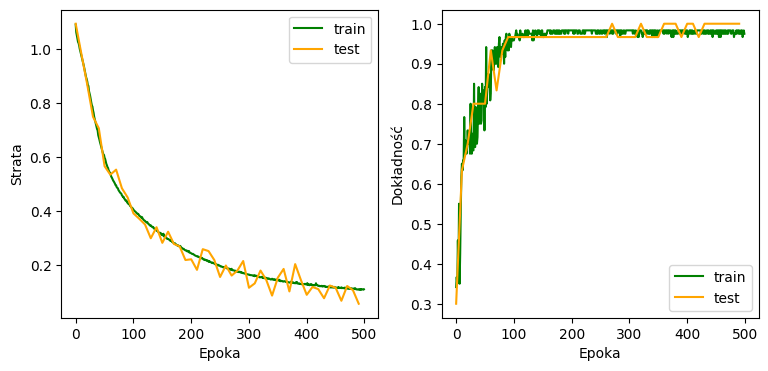

In [125]:
n_inputs = x_train.shape[1]
n_outputs = 3  # bo 3 klasy
n_hidden = 5

model = nn.Sequential(
    nn.Linear(n_inputs, n_hidden),
    # <- Nasz model jest liniowy -- brak nieliniowej f. aktywacji
    nn.Linear(n_hidden, n_outputs)
)

# Hiperparametry dla treningu:
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

history = train_model(model, train_loader, test_loader, optimizer)
plot_train_history(history)

# Zadanie -- klasyfikacja dla zbioru MNIST-1D

Zbiór MNIST-1D jest alternatywą dla zbioru MNIST-2D cyfr pisanych odręcznie. Jest od niego znacznie mniejszy, dane są wektorami jednowymiarowymi, które można interpretować jako pkt. definiujące kształt.

In [ ]:
# Instalacja pakietu ze zbiorem
!uv pip install mnist1d > /dev/null

import mnist1d

## Wizualizacja

Przykłady w zbiorze MNIST-1D powstały na podstawie jednowymiarowych **szablonów** kształtów cyfr od 0 do 9
złożonych z 12 punktów.

Szablony można zwizualizować, jak widać poniżej.

In [ ]:
templates = mnist1d.data.get_templates()
print("Templates for the MNIST-1D dataset:")
x = templates['x']
t = templates['t']
y = templates['y']
fig = mnist1d.utils.plot_signals(x, t, labels=y, ratio=1.33, dark_mode=True)

## Generowanie zbioru danych

Dzięki funkcji `make_dataset()` można wygenerować zbiór danych  o różnej liczności. Domyślnie jest to 4000 przykładów dla zb. treningowego oraz 1000 dla testowego.

In [ ]:
dataset = mnist1d.data.make_dataset(mnist1d.data.get_dataset_args())
x_train, y_train = dataset['x'], dataset['y']
x_test, y_test = dataset['x_test'], dataset['y_test']
x_train.shape, y_train.shape, x_test.shape, y_test.shape

In [ ]:
mnist1d.utils.plot_signals(x_train[:10], dataset['t'], y_train[:10],
                           zoom=max(dataset['t'])) ;

## Polecenie

Na podstawie podanego przykładu wytrenuj sieć typu MLP dla klasyfikacji zbioru MNIST-1D.

* Uwzględnij 2 architektury sieci: z **jedną** oraz **dwoma** warstwami ukrytymi
  (nie zapomnij o funkcji aktywacji dla warstw ukrytych)
* Łączna liczba neuronów ukrytych nie powinna przekraczać 100
* Trening powinien trwać 500 epok

Odpowiedz na pytania:
* Czy uczenie grupami poprawia jakość klasyfikacji w stosunku do przypadku, gdy mamy tylko jedną grupę (cały zbiór)?
  * Wypróbuj grupy o rozmiarach 32, 64 oraz 128
* Czy wyniki poprawią się, jeżeli zamiast `SGD` użyjemy algorytmu `Adam`?

In [ ]:
x_train, x_test = torch.Tensor(dataset['x']), torch.Tensor(dataset['x_test'])
y_train, y_test = torch.LongTensor(dataset['y']), torch.LongTensor(dataset['y_test'])